## SNN-Conversion
In this notebook we test direct and indirect conversion methods (via a classifier). 

Experiment List:
1. DQN-Training (How to train a conventional DQN and a spiking DQN using Surrogate Gradients (DSQN).)
2. Load-DQN (How to load a previously saved D(S)QN and how to save a replay dataset.)
3. Train-Classifier (How to train a spiking or non-spiking classifier on the saved replay data set.)
4. SNN-Conversion (How to convert a DQN and a Classifier to a SNN.)
5. Load in NEST (How to load a converted or directly trained spiking network in NEST.)
6. Conversion in pyNN with NEST or SpyNNaker (How to load spiking network in pyNN using NEST or SpyNNaker as backend.)

In [11]:
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import load_agent, train_classifier, SQN, FullyConnected, weight_conversion, save_model

# set seeds
torch.manual_seed(1)
random.seed(1)
gym_seed = 1

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div class="alert alert-block alert-warning">
<b>Attention:</b> If the directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# switch to the Result Directory
os.chdir('./../../Results/')
# choose the name of the result directory
result_directory = 'CartPole-Experiment4-Conversion'
# create the result directory (throws an error if the directory already exists)
os.makedirs(result_directory)
os.chdir(result_directory)

We start with the direct conversion method, where we convert a DQN. For this we convert the weights using the conversion function from the SQN file. For this we have to set the conversion method. 

In [4]:
# load the network, take care that you choose the same architecture and class as the model that is loaded
path_to_dqn = './../CartPole-A/DQN/trained/model.pt'
architecture = [4, 16, 16, 2]
policy_net = FullyConnected(architecture).to(device)
policy_net.load_state_dict(torch.load(path_to_dqn))

# choose the conversion method ('robust','model', or 'data')
CONVERSION_METHOD = 'robust' 
# for robust we additionally need to specify the path to the replay and the ppercentile
path_to_replay = './../CartPole-A/DQN/trained' # needed for data-based and robust
ppercentile = 0.99

# for the conversion the weights and biases need to be provided in the form [W1,W2,..,Wn] and [b1,b2,...,bn]
weights = []
biases = []
for l in range(0,len(policy_net.layers)):
    weights.append(policy_net.layers[l].weight.data)
    biases.append(policy_net.layers[l].bias.data)

# call the weight conversion method provided in the SQN module
converted_weights, converted_biases = weight_conversion(policy_net,weights,biases,device, 
                                                        normalization_method=CONVERSION_METHOD,
                                                        ppercentile=ppercentile,path_to_replay=path_to_replay)

We now save the converted weights and biases of the network.

In [5]:
# set up the spiking network
architecture = [4,16,16,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0)
# load the converted weights
converted.load(converted_weights,converted_biases)
# save the network
save_model(converted,'DQN-Converted')


After converting the weights, we now load the agent (see second tutorial) and compare it against the original DQN (for comparing also see third tutorial).

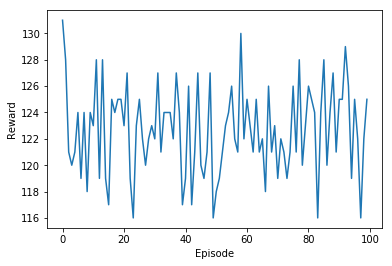

Similarity (Conversion Accuracy) after 12268 iterations: 60.68633844147375%
Complete
Mean:  122.68
Std:  3.3631394664371372
Similarity (Conversion Accuracy) after 12268 iterations: 60.68633844147375%


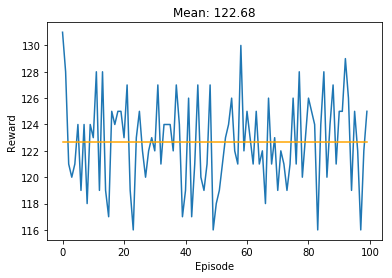

In [5]:
# load agent from the saved weights (alternatively use the SNN created above, they should be equivalent).
# set up the spiking network: choose correct architecture and the desired hyperparameters, encoding/decoding methods 
# and resetting method
# This script can be used to test the different methods: 
# Encoding: constant, poisson, equidistant
# Encoding: constant, poisson, equidistant. If poisson or equidistant is used, two_input_neurons should be set to True.
# Decoding: potential, spikes
# Resetting: subtraction, zero
# for simplicity, only one method is demonstrated in the notebook
architecture = [4,16,16,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0,two_input_neurons=False)
# load the saved weights
path_to_converted_dqn = './../CartPole-A/DQN-Converted/model.pt'
converted.load_state_dict(torch.load(path_to_converted_dqn))

# load the spiking agent and compare against original DQN 
# load the DQN
architecture = [4, 16, 16, 2]
dqn = FullyConnected(architecture).to(device)
dqn.load_state_dict(torch.load('./../CartPole-A/DQN/trained/model.pt'))                                                 

# simulate the spiking network 
env = 'CartPole-v0'
load_agent(env,converted,device,epsilon=0,gym_seed=gym_seed,save_replay=False,max_steps=500,num_episodes=100, render=True, compare_against=dqn)

In the next step we convert a classifier using the same methods as for the DQN.

In [9]:
# load the network, take care that you choose the same architecture and class as the model that is loaded
path_to_classifier = './../CartPole-A/Classifier/trained/model.pt'
architecture = [4, 16, 16, 2]
policy_net = FullyConnected(architecture).to(device)
policy_net.load_state_dict(torch.load(path_to_classifier))

# choose the conversion method ('robust','model', or 'data')
CONVERSION_METHOD = 'robust' 
# for robust we additionally need to specify the path to the replay and the ppercentile
path_to_replay = './../CartPole-A/DQN/trained' # needed for data-based and robust
ppercentile = 0.99

# for the conversion the weights and biases need to be provided in the form [W1,W2,..,Wn] and [b1,b2,...,bn]
weights = []
biases = []
for l in range(0,len(policy_net.layers)):
    weights.append(policy_net.layers[l].weight.data)
    biases.append(policy_net.layers[l].bias.data)

# call the weight conversion method provided in the SQN module
converted_weights, converted_biases = weight_conversion(policy_net,weights,biases,device, normalization_method = CONVERSION_METHOD,
                                                        ppercentile=ppercentile,path_to_replay=path_to_replay)
# save the network
# set up the spiking network
architecture = [4,16,16,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='coonstant',decoding='potential',reset='subtraction',threshold=1.0)
# load the converted weights
converted.load(converted_weights,converted_biases)
# save the network
save_model(converted,'Classifier-Converted')

Load the pretrained weights and simulate the agent for 100 episodes. This time we compare against the original classifier in order to see how well the conversion is working. As training a classifier already changes the network, one could also compare against the original DQN.

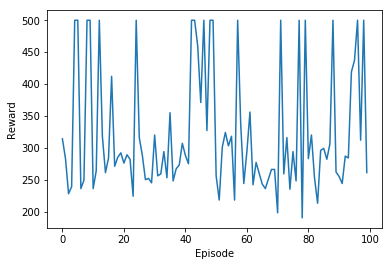

Similarity (Conversion Accuracy) after 32109 iterations: 94.19788844249275%
Complete
Mean:  321.09
Std:  95.2997498592327
Similarity (Conversion Accuracy) after 32109 iterations: 94.19788844249275%


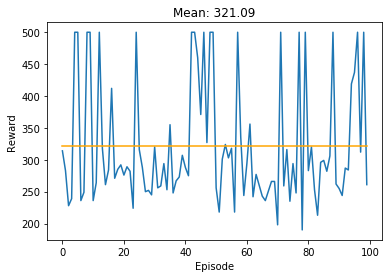

In [10]:
# load agent from the saved weights (alternatively use the SNN created above, they should be equivalent).
# set up the spiking network: choose correct architecture and the desired hyperparameters, encoding/decoding methods 
# and resetting method
# This script can be used to test the different methods: 
# Encoding: constant, poisson, equidistant. If poisson or equidistant is used, two_input_neurons should be set to True.
# Decoding: potential, spikes
# Resetting: subtraction, zero
# for simplicity, only one method is demonstrated in the notebook
architecture = [4,16,16,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0, two_input_neurons=False)
# load the saved weights
path_to_converted_classifier = './../CartPole-A/Classifier-Converted/model.pt'
converted.load_state_dict(torch.load(path_to_converted_classifier))

# load the spiking agent and compare against original Classifier
# load the Classifier
architecture = [4, 16, 16, 2]
classifier = FullyConnected(architecture).to(device)
classifier.load_state_dict(torch.load('./../CartPole-A/Classifier/trained/model.pt'))                                                 

# simulate the spiking network 
env = 'CartPole-v0'
load_agent(env,converted,device,epsilon=0,gym_seed=gym_seed,save_replay=False,max_steps=500,num_episodes=100, render=True, compare_against=classifier)

Using the tutorials 1 to 4 allows to reproduce all our thesis results for CartPole (and for MountainCar by changing the environment and hyperparameters) except for the ones which use the neuron simulators NEST and PyNN as well as the neuromorphic hardware chip SpiNNaker. In the remaining two tutorials we demonstrate how our networks can be ported to these simulators. 